### Description
This is skeleton code for **Exercise 1: classification** for *L335 Machine Visual Perception*. For this task, we will formulate a classification network to predict the labels of images obtained from the FashionMNIST dataset and explore several key concepts in the design and training of the network.

You can run the rest of this file without any changes as a sanity check.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import dill

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
if device == 'cuda':
    print(torch.cuda.get_device_name())

/home/bad35/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using cuda device
Tesla P100-PCIE-16GB


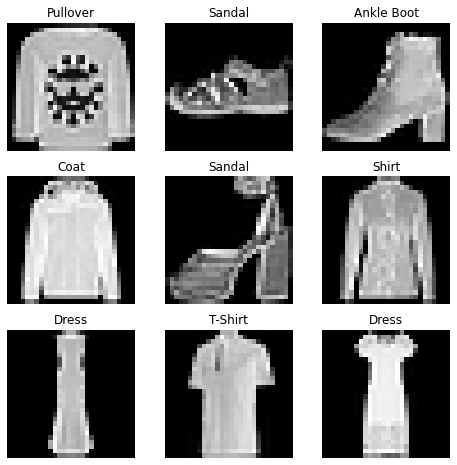

In [2]:
# download the training and testing dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_batch_size = 64
test_batch_size = 10

# initialise the data loader
trainloader = DataLoader(training_data, batch_size=train_batch_size, shuffle=True, num_workers=2)

testloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True, num_workers=2)

# establish the labels map
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# preview the dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
# initialise a 3-layer fully-connected network
class BasicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_hidden = 512
        self.linear1 = nn.Linear(28*28, self.n_hidden)
        self.linear2 = nn.Linear(self.n_hidden, self.n_hidden)
        self.linear3 = nn.Linear(self.n_hidden, 10)
        self.act_ReLU = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.linear1(x)
        x = self.act_ReLU(x)
        x = self.linear2(x)
        x = self.act_ReLU(x)
        x = self.linear3(x)
        return x

In [4]:
basic_model = BasicNet().to(device)
print(basic_model)

# define the loss and optimiser
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(basic_model.parameters(), lr=0.001, momentum=0.9)

BasicNet(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=10, bias=True)
  (act_ReLU): ReLU()
)


In [5]:
# helper function to compute the model accuracy on the specified dataset
def compute_accuracy(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return correct, test_loss

In [6]:
# training
def train(model, optimizer, loss_fn, n_epochs=10, trainloader=trainloader):
    start = time.time()

    train_accuracy, train_loss = compute_accuracy(trainloader, model, loss_fn)
    test_accuracy, test_loss = compute_accuracy(testloader, model, loss_fn)
    
    history = {
        'accuracy': {
            'train': [train_accuracy],
            'test': [test_accuracy]
        },
        'loss': {
            'train': [train_loss],
            'test': [test_loss]
        }
    }
    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    
            # zero the gradients of the training parameters
            optimizer.zero_grad()
    
            # forward feed
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
    
            # backpropagate
            loss.backward()
    
            # update the training parameters
            optimizer.step()
    
            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print('epoch:', epoch + 1, 'batch:', i, 'loss:', running_loss / 200)
                running_loss = 0.0
    
        train_accuracy, train_loss = compute_accuracy(trainloader, model, loss_fn)
        test_accuracy, test_loss = compute_accuracy(testloader, model, loss_fn)
    
        print('accuracy on training set:', train_accuracy)
        print('accuracy on test set:', test_accuracy)
        
        history['accuracy']['train'].append(train_accuracy)
        history['accuracy']['test'].append(test_accuracy)
        history['loss']['train'].append(train_loss)
        history['loss']['test'].append(test_loss)        
    
    elapsed_time = datetime.timedelta(seconds=time.time()-start)
    print('Finished Training')
    print(f'Elapsed time: {elapsed_time} ({elapsed_time/n_epochs} per epoch)')
    
    return history

In [7]:
train_epochs = 20

In [8]:
try:
    basic_history = dill.load(open(f'basic_model_history.pkl', 'rb'))
    print(f'Loaded basic model data from file.')
except:
    print(f'Basic model data not found. Training model...')
    basic_history = train(basic_model, optimizer, loss_fn, n_epochs=train_epochs)
    dill.dump(basic_history, open(f'basic_model_history.pkl', 'wb'))

Loaded basic model data from file.


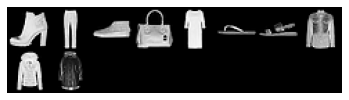

GroundTruth:  Ankle Boot Trouser Sneaker Bag   Dress Sandal Sandal Shirt Coat  Coat 
Predicted:  T-Shirt Ankle Boot Sandal T-Shirt Bag   Bag   Dress T-Shirt T-Shirt Sandal


In [9]:
# visualise the performance on the test data
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels_map[int(labels[j])]:5s}' for j in range(test_batch_size)))

outputs = basic_model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{labels_map[int(predicted[j])]:5s}' for j in range(test_batch_size)))

### Task 1

The current forward model is a basic three-layer fully connected network (FCN). As introduced in the lecture, there are many possibilities, such as a CNN, to tailor the network architecture to better distil the local features of images. The first task is to update the network architecture to a CNN with three convolutional layers and two FC layers. Choose the hyperparameters of the CNN (e.g. the number of output channels, kernel size, hidden layer size, etc. of the convolutional layers, pooling layer, and the FC layers) such that the total number of training parameters is similar to that of the basic net. Retrain the network with the same epoch and batch size and compare the training and test accuracy of the CNN with the basic net.

**Deliverable:** Report the choice of the hyperparameters of your CNN and show the calculation of the number of training parameters. Show a quantitative comparison of the model accuracy of the basic net and the CNN on the training and test data with a plot of accuracy vs. epochs. Report whether the model is under-fitted, well-fitted, or over-fitted, explain the possible causes, and suggest potential solutions. Visualise the feature maps of each convolutional layer.

In [10]:
# initialise a 3-layer fully-connected network
class ConvNet(nn.Module):
    def __init__(self, n_hidden, conv_channels, kernel_size):
        super().__init__()
        self.n_hidden = n_hidden
        self.conv_channels = conv_channels
        
        self.conv1 = nn.Conv2d(1, self.conv_channels, kernel_size, padding='same')
        self.conv2 = nn.Conv2d(self.conv_channels, self.conv_channels, kernel_size, padding='same')
        self.conv3 = nn.Conv2d(self.conv_channels, self.conv_channels, kernel_size, padding='same')
        
        self.linear1 = nn.Linear(self.conv_channels*16*16, self.n_hidden)
        self.linear2 = nn.Linear(self.n_hidden, self.n_hidden)
        self.linear3 = nn.Linear(self.n_hidden, 10)
        
        self.pool = nn.MaxPool2d(kernel_size, stride=1)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.ReLU(self.pool(x))
        
        x = self.conv2(x)
        x = self.ReLU(self.pool(x))
        
        x = self.conv3(x)
        x = self.ReLU(self.pool(x))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
                
        x = self.ReLU(self.linear1(x))
        x = self.ReLU(self.linear2(x))
        x = self.ReLU(self.linear3(x))
        return x

In [11]:
conv_model = ConvNet(n_hidden=256, conv_channels=9, kernel_size=5).to(device)
print(conv_model)

# define the loss and optimiser
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_model.parameters(), lr=0.001, momentum=0.9)

ConvNet(
  (conv1): Conv2d(1, 9, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(9, 9, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv3): Conv2d(9, 9, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (linear1): Linear(in_features=2304, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (ReLU): ReLU()
)


In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Basic network training parameters: {count_parameters(basic_model):,}')
print(f'Convolutional network training parameters: {count_parameters(conv_model):,}')

Basic network training parameters: 669,706
Convolutional network training parameters: 662,744


In [13]:
try:
    conv_history = dill.load(open(f'conv_model_history.pkl', 'rb'))
    print(f'Loaded convolutional model data from file.')
except:
    print(f'Convolutional model data not found. Training model...')
    conv_history = train(conv_model, optimizer, loss_fn, n_epochs=train_epochs)
    dill.dump(conv_history, open(f'conv_model_history.pkl', 'wb'))

Loaded convolutional model data from file.


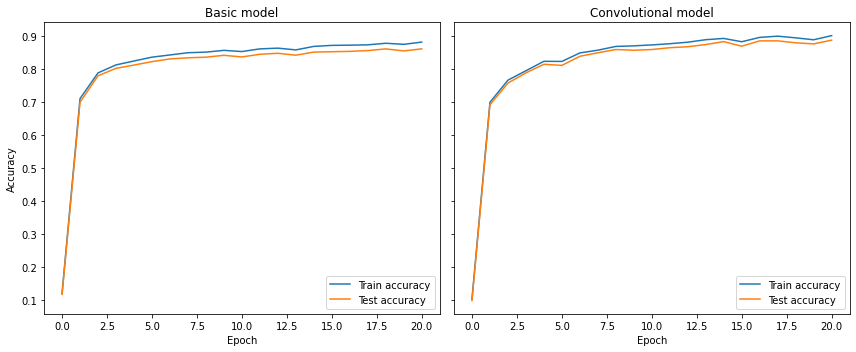

In [14]:
_, axs = plt.subplots(1,2, figsize=(12,5), sharey=True)

axs[0].set_title('Basic model')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].plot(basic_history['accuracy']['train'], label='Train accuracy')
axs[0].plot(basic_history['accuracy']['test'], label='Test accuracy')
axs[0].legend(loc='lower right')

axs[1].set_title('Convolutional model')
axs[1].set_xlabel('Epoch')
axs[1].plot(conv_history['accuracy']['train'], label='Train accuracy')
axs[1].plot(conv_history['accuracy']['test'], label='Test accuracy')
axs[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

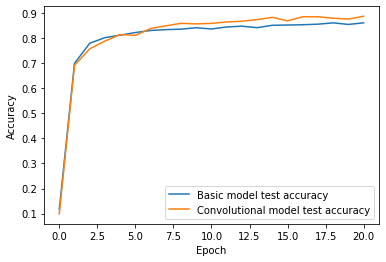

In [15]:
plt.plot(basic_history['accuracy']['test'], label='Basic model test accuracy')
plt.plot(conv_history['accuracy']['test'], label='Convolutional model test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()

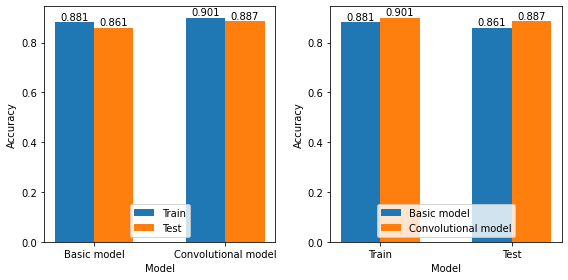

In [16]:
x = np.arange(2)
width = 0.3

_, axs = plt.subplots(1, 2, figsize=(8,4))

train_bars = axs[0].bar(x-width/2, [basic_history['accuracy']['train'][-1], conv_history['accuracy']['train'][-1]], width, color='tab:blue', label='Train')
test_bars = axs[0].bar(x+width/2, [basic_history['accuracy']['test'][-1], conv_history['accuracy']['test'][-1]], width, color='tab:orange', label='Test')

axs[0].bar_label(train_bars, fmt='{:.3f}')
axs[0].bar_label(test_bars, fmt='{:.3f}')

axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Model')
axs[0].set_xticks(x, ['Basic model', 'Convolutional model'])
axs[0].legend(loc='lower center')

basic_bars = axs[1].bar(x-width/2, [basic_history['accuracy']['train'][-1], basic_history['accuracy']['test'][-1]], width, color='tab:blue', label='Basic model')
conv_bars = axs[1].bar(x+width/2, [conv_history['accuracy']['train'][-1], conv_history['accuracy']['test'][-1]], width, color='tab:orange', label='Convolutional model')

axs[1].bar_label(basic_bars, fmt='{:.3f}')
axs[1].bar_label(conv_bars, fmt='{:.3f}')

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Model')
axs[1].set_xticks(x, ['Train', 'Test'])
axs[1].legend(loc='lower center')

plt.tight_layout()
plt.show()

For my CNN, I kept the parameters the same for all of the convolutional layers.  For my CNN, I kept the parameters the same for all of the convolutional layers. For all convolutional layers I introduced padding and for the pooling layers I used a stride of 1, as I found this produced the best results consistently and prevented the dimensionality from rapidly decreasing (since 28x28 isn't very large). For the convolutional portion of the network, I used a kernel size of 5 and produced 9 output-channels, while for the linear portion of the model I used a hidden size of 128. The basic model had 669,706 training parameters while the convolutional model has 662,744 (see my `count_parameters` function above for how these were computed).

Overall the difference in performance between the basic model and the convolutional model is relatively small, but it is still notable (about 2.6% improvement on the test set and 2% on the training set). Additionally, the convolutional model began outperforming the basic model in only about 5 epochs. Both models are slightly overfitted, having an approximate 2% reduction in performance for the test set compared to the training set for the basic model, and 1.4% for the convolutional model. However, this different is rather small, suggesting a reasonably good fit. This overfitting may potentially be resolved using smarter techniques, such as edge detection.

### Task 2
In addition to the network design, training parameters and algorithms also influence the performance of the network. The second task is to retrain your CNN constructed in task 1 with a different learning rate and batch size.

**Deliverable:** Show a quantitative comparison of the model accuracy on the training and test data with a plot of accuracy vs. epochs with a learning rate of 0.1, 0.001, and 0.00001. Summarise the difference in performance and explain the cause. Fixing the learning rate to be 0.001, show a quantitative comparison of the model accuracy on the training and test data with a plot of accuracy vs. epochs with a batch size of 4, 64, and 512. Summarise the difference in performance and explain the cause.

In [17]:
loss_fn = nn.CrossEntropyLoss()

lrs = {
    .1: None, 
    .001: None,
    .00001: None
}

for lr in lrs.keys():
    try:
        lrs[lr] = dill.load(open(f'lr_{lr}.pkl', 'rb'))
        print(f'Loaded lr={lr} data from file.')
    except:
        print(f'lr={lr} data not found. Training model...')
        lr_conv_model = ConvNet(n_hidden=256, conv_channels=9, kernel_size=5).to(device)
        optimizer = torch.optim.SGD(lr_conv_model.parameters(), lr=lr, momentum=0.9)
        
        lrs[lr] = train(lr_conv_model, optimizer, loss_fn, n_epochs=train_epochs)
        dill.dump(lrs[lr], open(f'lr_{lr}.pkl', 'wb'))

Loaded lr=0.1 data from file.
Loaded lr=0.001 data from file.
Loaded lr=1e-05 data from file.


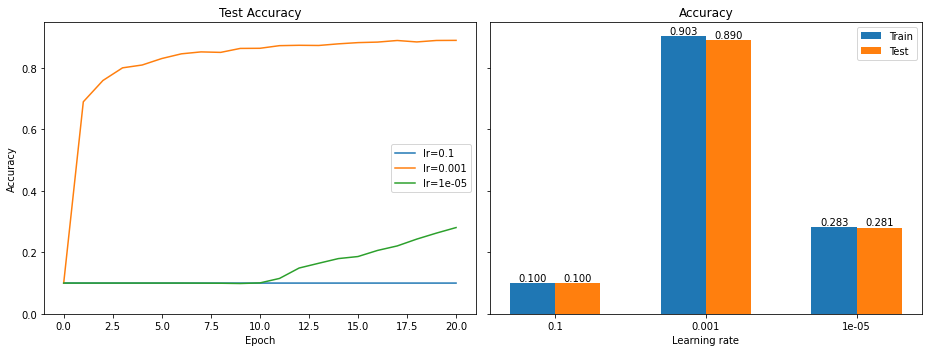

In [18]:
_, axs = plt.subplots(1,2, figsize=(13,5), sharey=True)

for lr in lrs.keys():
    axs[0].plot(lrs[lr]['accuracy']['test'], label=f'lr={lr}')
axs[0].set_title('Test Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend()

width = 0.3
x = np.arange(len(lrs))

lr_train_bars = axs[1].bar(x-width/2, [lrs[lr]['accuracy']['train'][-1] for lr in lrs.keys()], width, label=f'Train')
lr_test_bars = axs[1].bar(x+width/2, [lrs[lr]['accuracy']['test'][-1] for lr in lrs.keys()], width, label=f'Test')
axs[1].bar_label(lr_train_bars, fmt='{:.3f}')
axs[1].bar_label(lr_test_bars, fmt='{:.3f}')
axs[1].set_title('Accuracy')
axs[1].set_xticks(np.arange(len(lrs)), lrs.keys())
axs[1].set_xlabel('Learning rate')
axs[1].legend()

plt.tight_layout()
plt.show()

Based on this experiment, we can see that the learning rate strongly impacts how fast the model learns and to what degree. In the case of `lr=0.1`, the learning rate is so large that the model fails to learn at all, resulting in completely random predictions. This is because the learning rate is so large that the optimizer always overshoots any minima it is optimizing for. With `lr=0.00001` the model fails to fully generalize, but does begin learning very slowly toward the end of the training. This is because the movements of the optimizer are so short that it takes a very long time to actually begin approaching a minima.[^1] Notably, with this learning rate the train and test performance is very similar (though admittedly very poor). These contrast significantly from `lr=0.001`, which does successfully learn, reaching a test accuracy of 89%. This is because this learning rate is large enough to approach the minima relatively quickly, but small enough that it doesn't overshoot it (or at least, not as much).

[^1]: Note: On a few experimental trials with `lr=0.00001` the model failed to learn anything for the entire duration of training.

In [19]:
loss_fn = nn.CrossEntropyLoss()

batch_sizes = {
    512: None,
    64: None,
    4: None
}

for batch_size in batch_sizes.keys():
    try:
        batch_sizes[batch_size] = dill.load(open(f'bs_{batch_size}.pkl', 'rb'))
        print(f'Loaded batch_size={batch_size} data from file.')
    except:
        print(f'batch_size={batch_size} data not found. Training model...')
        bs_trainloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)
        
        bs_conv_model = ConvNet(n_hidden=256, conv_channels=9, kernel_size=5).to(device)
        optimizer = torch.optim.SGD(bs_conv_model.parameters(), lr=0.001, momentum=0.9)
    
        batch_sizes[batch_size] = train(bs_conv_model, optimizer, loss_fn, n_epochs=train_epochs, trainloader=bs_trainloader)
        dill.dump(batch_sizes[batch_size], open(f'bs_{batch_size}.pkl', 'wb'))

Loaded batch_size=512 data from file.
Loaded batch_size=64 data from file.
Loaded batch_size=4 data from file.


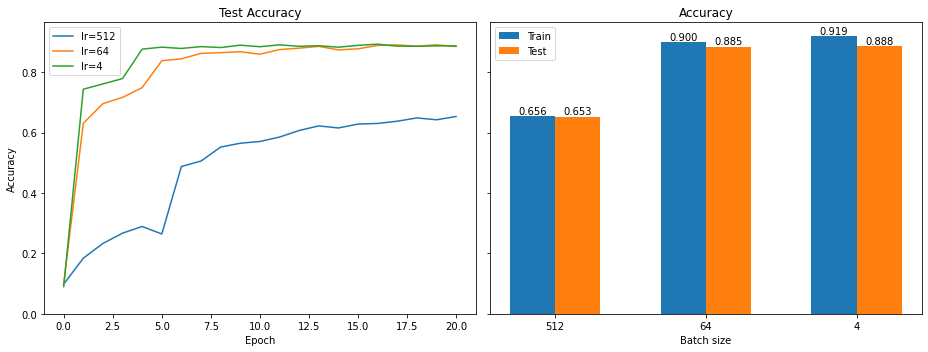

In [20]:
_, axs = plt.subplots(1,2, figsize=(13,5), sharey=True)

for bs in batch_sizes.keys():
    axs[0].plot(batch_sizes[bs]['accuracy']['test'], label=f'lr={bs}')
axs[0].set_title('Test Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend()

width = 0.3
x = np.arange(len(batch_sizes))

bs_train_bars = axs[1].bar(x-width/2, [batch_sizes[bs]['accuracy']['train'][-1] for bs in batch_sizes.keys()], width, label=f'Train')
bs_test_bars = axs[1].bar(x+width/2, [batch_sizes[bs]['accuracy']['test'][-1] for bs in batch_sizes.keys()], width, label=f'Test')
axs[1].bar_label(bs_train_bars, fmt='{:.3f}')
axs[1].bar_label(bs_test_bars, fmt='{:.3f}')
axs[1].set_title('Accuracy')
axs[1].set_xticks(np.arange(len(batch_sizes)), batch_sizes.keys())
axs[1].set_xlabel('Batch size')
axs[1].legend()

plt.tight_layout()
plt.show()

Based on this experiment, the batch size has a relatively minor impact on model accuracy once fully trained, but significantly impacts the dynamics of how fast the model trains. This is because with smaller batch sizes, a much greater number of expensive operations need to occur, causing training to take much longer per epoch. However, based on `batch_size=4`, having a smaller batch size leads to very slightly better final test performance, but also notably more overfitting (test accuracy from batch size of 64 to 4 increases by only 0.3%, while train accuracy increases by 1.9%). Looking at `batch_size=512`, we see lower model accuracy, but the model also had not fully converged by the end of training, and would likely approach similar performance to the other models if trained longer. Additionally, the model trained with larger batch size appeared to have less overfitting, with train and test accuracy only differing by 0.3%. The differences in overfitting occur because using a small batch size causes the optimizer to consider only a small number of samples when calculating its gradients, resulting in model adjustments due to microscopic effects that may not generalize as well to the broader behavior. By contrast, having a larger batch size allows for better consideration of the average (general) behavior. That said, while we did not explore it here, having too large of a batch size can also result in overfitting or underfitting due to being unable to consider microscoping, per-sample behaviors as well. This is why the model trained on a large batch size did not converge before training finished. 